# Aassignment 3 Part A : Decision Tree & Random Forest

In [1]:
from xclib.data import data_utils
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import itertools
from tqdm import tqdm
from time import time

from joblib import Parallel, delayed
import multiprocessing as mp
import matplotlib.pyplot as plt
import math

from scipy.interpolate import make_interp_spline, BSpline

In [2]:
X_train = data_utils.read_sparse_file('./data/train_x.txt', n_features=482).toarray()
X_test = data_utils.read_sparse_file('./data/test_x.txt', n_features=482).toarray()
X_val = data_utils.read_sparse_file('./data/valid_x.txt', n_features=482).toarray()

Y_train = np.array(open('./data/train_y.txt','r').read().strip().split('\n'), dtype=int)
Y_test = np.array(open('./data/test_y.txt','r').read().strip().split('\n'), dtype=int)
Y_val = np.array(open('./data/valid_y.txt','r').read().strip().split('\n'), dtype=int)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_val.shape, Y_val.shape)

(64713, 482) (64713,)
(21571, 482) (21571,)
(21572, 482) (21572,)


In [3]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))
print(np.unique(Y_val, return_counts=True))

#Almost balanced dataset

(array([0, 1]), array([30560, 34153]))
(array([0, 1]), array([10151, 11420]))
(array([0, 1]), array([10302, 11270]))


In [4]:
ind_lst = []
for i in range(X_train.shape[1]):
    if (X_train[:,i].min() == 0) and (X_train[:,i].max() == 0) and X_val[:,i].min()==0 and X_val[:,i].max()==0:
        ind_lst.append(i)

print('%d columns were having only zero values.'%(len(ind_lst)))

#Removing columns with zero values
X_train = np.delete(X_train, ind_lst, axis=1)
X_test = np.delete(X_test, ind_lst, axis=1)
X_val = np.delete(X_val, ind_lst, axis=1)

#shape of datasets after Removing columns with zero values
print('Shape of X_train',X_train.shape)
print('Shape of X_test',X_test.shape)
print('Shape of X_val',X_val.shape)

219 columns were having only zero values.
Shape of X_train (64713, 263)
Shape of X_test (21571, 263)
Shape of X_val (21572, 263)


## Question (a): Implementing Decision Tree From scratch :

In [5]:
class DTNode:
    '''
        Class representing node of 
    '''
    def __init__(self, splitFeat=None, splitVal=None, majorityClass=None, parent=None, isLeft=True, X=None, Y=None, isLeaf=False):
        self.splitFeat = splitFeat
        self.splitVal = splitVal
        self.majorityClass = majorityClass
        self.isLeaf = False
        self.left = None
        self.right = None
        self.X, self.Y = X, Y
        self.nodes_subtree = None
        
    def is_leaf(self):
        return self.splitFeat is None or self.isLeaf 
        
    def __str__(self):
        return 'SplitFeat : '+str(self.splitFeat)+'\nSplitVal : '+str(self.splitVal)+'\nMajorityClass : '+str(self.majorityClass)+'\n'
    
    def __repr__(self):
        return 'SplitFeat : '+str(self.splitFeat)+'\nSplitVal : '+str(self.splitVal)+'\nMajorityClass : '+str(self.majorityClass)+'\n'

In [6]:
class DecisionTreeClassifier:
    '''
        Implementation of decision tree classifier
        
        Parameters:
        *******************
            
        get_train_data(Default:False) : [boolean]
            If true then train, test and Validation accuracy recorded
            after adding record_data_frequency number of nodes

        record_data_frequency(Default:100) : [int]
            After how many nodes to record accuracy data
                
        Attributes:
        *******************
        
        cnt : [int]
            numer of node in tree
        root : [DTNode]
            Root of the decision Tree
        train_data : [Dictionary]
            Dictionary containing accuracies over Train, Test and Validation Datasets
            recorded as tree grows (You need to set get_train_data=True to get this)
                
        Methods: 
        *******************
        fit(self, X, Y[, X_test, Y_test, X_val, Y_val]) : [None]
            This method builds decision tree iteratively using 
            X and Y as training Dataset [and records accuracies].
            (If you have set get_train_data=True then pass X_test, Y_test and X_val, Y_val)

        predict(self, X) : [list]
            Returns list of predicted class labels for datapoints in X

        score(self, X, Y_true) : [float]
            Returns accuracy over dataset X and ground truth Y_true

        plot_training_data(self) : [None]
            Plots number of nodes v/s accuracies if get_train_data=True
    '''
    def __init__(self, get_train_data=False, record_data_frequency=100, get_prune_data=False):
        self.root = None
        self.cnt = 0
        self.leafNodes = 0
        self.get_train_data = get_train_data
        self.record_data_frequency = record_data_frequency
        self.get_prune_data=get_prune_data
        if self.get_train_data:
            self.train_data = {'train_acc':[], 'test_acc':[], 'val_acc':[]}
        if self.get_prune_data:
            self.prune_data = {'train_acc':[], 'test_acc':[], 'val_acc':[], 'nodes':[]}
    
    def __str__(self):
        return 'DecisionTreeClassifier\n\nParameters : \n\tget_train_data='+str(self.get_train_data)+'\n\trecord_data_frequency='+str(self.record_data_frequency)+\
                '\n\nAttributes : \n\tTotal Number of nodes='+str(self.get_number_of_nodes()[0])+'\n\tNumber of leafe nodes='+str(self.get_number_of_nodes()[1])
    
    def __repr__(self):
        return 'DecisionTreeClassifier\n\nParameters : \n\tget_train_data='+str(self.get_train_data)+'\n\trecord_data_frequency='+str(self.record_data_frequency)+\
                '\n\nAttributes : \n\tTotal Number of nodes='+str(self.get_number_of_nodes()[0])+'\n\tNumber of leafe nodes='+str(self.get_number_of_nodes()[1])
        
    def fit(self, X, Y, X_test=None, Y_test=None, X_val=None, Y_val=None):
        '''
            Builds Tree using viven Train Dataset
        '''
        if self.get_train_data and (X_test is None or Y_test is None or X_val is None or Y_val is None):
            raise Exception('Please pass test and validation data to get train_data or pass get_train_data=False')
        
        queue = []
        X_train = X.copy()
        Y_train = Y.copy()
        self.root = DTNode(X=X, Y=Y)
        queue.append(self.root)
        
        while queue!=[]:
            self.cnt+=1

            node = queue.pop(0)
            X_, Y_ = node.X, node.Y
            n_samples_, n_feat_ = X_.shape
            nY1_ = (Y_==1).sum()
            nY0_ = n_samples_ - nY1_
            majClass = 1 if nY1_>nY0_ else 0
            node.majorityClass=majClass
            if (nY1_ == 0) or (nY0_==0):
                self.leafNodes+=1
                node.isLeaf=True
                if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
                    self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
                continue
            else:
                bestSplit_, median_, maxIG_ = self._getBestSplit(X_, Y_)
                if(bestSplit_==-np.inf):# or maxIG_==0:
                    self.leafNodes+=1
                    node.isLeaf=True
                    if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
                        self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
                    continue
                node.splitFeat = bestSplit_
                node.splitVal = median_
                node.left = DTNode(majorityClass=majClass,\
                                   X=X_[X_[:,bestSplit_]<=median_], Y=Y_[X_[:,bestSplit_]<=median_])
                node.right = DTNode(majorityClass=majClass,\
                                   X=X_[X_[:,bestSplit_]>median_], Y=Y_[X_[:,bestSplit_]>median_])
                queue.append(node.left)
                queue.append(node.right)
                node.X=None
                node.Y=None
            if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
                self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
        if self.get_train_data:
                self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
            
    
        
    def _record_accuracies(self, X_train, Y_train, X_test, Y_test, X_val, Y_val):
        '''
            Records train, test and validation accuracy in train_data dictionary at given state of the tree
        '''
        self.train_data['train_acc'].append(self.score(X_train, Y_train))
        self.train_data['test_acc'].append(self.score(X_test, Y_test))
        self.train_data['val_acc'].append(self.score(X_val, Y_val))
        
    def _getBestSplit(self, X, Y):  
        '''
            Returns (optimal_split, optimal_median, max_IG)
                optimal_split : feature index of dataset X splitting which maximizes Info. gain
                optimal_median : median of optimal_split feature
                max_IG : maximum Information gain across all features
        '''
        n_samples, n_feat = X.shape
        optimal_split, optimal_median = -np.inf, -np.inf
        max_IG = -np.inf
        if X.size%2 == 0:
            median_arr = np.median(np.vstack((np.min(X, axis=0), X)), axis=0)
        else:
            median_arr = np.median(X, axis=0)
        for i in range(n_feat):
            median = median_arr[i]
            ig = self._getInformationGain(X,Y,i,median)
            if ig > max_IG:
                max_IG = ig
                optimal_split = i
                optimal_median = median
        return (optimal_split, optimal_median, max_IG)
        
    def _entropy(self, X, Y):
        '''
            This method computes entropy of given node
        '''
        n_samples, n_feat = X.shape
        nY1 = (Y==1).sum()
        nY0 = n_samples-nY1
        
        if n_samples==0:
            return np.inf
        elif nY1==0 or nY0==0:
            return 0
        else:
            return (-nY0*math.log2(nY0/n_samples)-nY1*math.log2(nY1/n_samples))/n_samples
    
    def _getInformationGain(self, X, Y, i, median):
        '''
            return information gain if we split with ith Feature
        '''
        entBefore = self._entropy(X,Y)
        
        X_lte = X[X[:,i]<=median]
        Y_lte = Y[X[:,i]<=median]
        X_gt = X[X[:,i]>median]
        Y_gt = Y[X[:,i]>median]
        
        entAfter = ((Y_lte.shape[0])*self._entropy(X_lte, Y_lte) + (Y_gt.shape[0])*self._entropy(X_gt, Y_gt))/(Y.shape[0])
        return (entBefore-entAfter)
    
    def score(self, X, Y_true):
        '''
            Return accuracy score over dataset X and actual label Y
        '''
        return (self.predict(X)==Y_true).sum()/Y_true.shape[0]
    
    def predict(self, X):
        '''
            Returns prediction for given Dataset X
        '''
        pred=[]
        for row in X:
            node=self.root
            while(not node.is_leaf()):
                if row[node.splitFeat]<=node.splitVal:
                    node=node.left
                elif row[node.splitFeat]>node.splitVal:
                    node=node.right
            pred.append(node.majorityClass)
        return pred
    
    def _set_indices(self, node, X, indices):
        if node.is_leaf():
            node.val_indices = indices
        else:
            lt_indices = np.logical_and((X[:,node.splitFeat]<=node.splitVal), indices)
            rt_indices = np.logical_and((X[:,node.splitFeat]>node.splitVal), indices)
            node.val_indices = np.argwhere(indices).flatten()
            self._set_indices(node.left, X, lt_indices)
            self._set_indices(node.right, X, rt_indices)
    
    def _post_order_lst(self, node, lst):
        if node:
            self._post_order_lst(node.left, lst)
            self._post_order_lst(node.right, lst)
            lst.append(node)
    
    def _accuracy_score(self, Y_pred, Y_true):
        return (Y_pred == Y_true).sum()/Y_true.size
    
    def get_number_of_nodes(self):
        cnt=0
        leaves=0
        queue = [self.root]
        while queue!=[]:
            cnt+=1
            node=queue.pop(0)
            if node.is_leaf():
                leaves+=1
                continue
            else:
                queue.append(node.left); queue.append(node.right)
        return (cnt, leaves)
    
    def prune(self, X_val, Y_val, X_train=None, Y_train=None, X_test=None, Y_test=None):
        if self.get_train_data and (X_test is None or Y_test is None or X_train is None or Y_train is None):
            raise Exception('Please pass train and Test data to get prune_data or pass get_prune_data=False')
        
        self._set_indices(self.root, X_val, [True]*Y_val.size)
        node_lst=[]
        self._post_order_lst(self.root, node_lst)
        
        pred = np.array(self.predict(X_val))
        best_val_acc = self._accuracy_score(pred, Y_val)
        cnt=0
        for node in (node_lst):
            if self.get_prune_data and (cnt%self.record_data_frequency)==0:
                self._record_prune_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)
            cnt+=1
            if node.is_leaf() or (node.val_indices.size)==0:
                continue
            else:
                pred_tmp = pred.copy()
                pred_tmp[node.val_indices]=node.majorityClass
                val_acc = self._accuracy_score(pred_tmp, Y_val)
                if val_acc >= best_val_acc:
                    pred, best_val_acc = pred_tmp, val_acc
                    node.isLeaf, node.left, node.right, node.splitFeat, node.splitVal=True, None, None, None, None
                else:
                    node.isLeaf=False
        
        if self.get_prune_data:
            self._record_prune_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)
    
    def _record_prune_data(self, X_train, Y_train, X_val, Y_val, X_test, Y_test):
        self.prune_data['nodes'].append(self.get_number_of_nodes()[0])
        self.prune_data['val_acc'].append(self.score(X_val, Y_val))
        self.prune_data['test_acc'].append(self.score(X_test, Y_test))
        self.prune_data['train_acc'].append(self.score(X_train, Y_train))
    
    def plot_training_data(self):
        '''
            Plots train, test and validation accuracy as number of nodes increases during training
        '''
        
        if self.get_train_data:
            plt.figure(figsize=(12,8))
            n_nodes_lst = list(range(1,(len(self.train_data['train_acc'])-1)*self.record_data_frequency, self.record_data_frequency))
            n_nodes_lst.append(self.cnt)
            plt.plot(n_nodes_lst, self.train_data['train_acc'], label='Train Accuracy')
            plt.plot(n_nodes_lst, self.train_data['test_acc'], label='Test Accuracy')
            plt.plot(n_nodes_lst, self.train_data['val_acc'], label='Validation Accuracy')
            plt.legend()
            plt.xlabel('Number of nodes')
            plt.ylabel('Accuracies')
            plt.title('Number of nodes v/s Accuracies as we train the classifier')
            plt.show()
        else:
            raise Exception('Please pass get_train_data=True to get this plot')
    
    def plot_pruning_data(self):
        '''
            Plots train, test and validation accuracy as number of nodes increases during training
        '''
        if self.get_train_data:
            plt.figure(figsize=(12,8))
            n_nodes_lst = self.prune_data['nodes']
            plt.plot(n_nodes_lst, self.prune_data['train_acc'], label='Train Accuracy')
            plt.plot(n_nodes_lst, self.prune_data['test_acc'], label='Test Accuracy')
            plt.plot(n_nodes_lst, self.prune_data['val_acc'], label='Validation Accuracy')
            plt.legend()
            plt.xlabel('Number of nodes')
            plt.ylabel('Accuracies')
            plt.title('Number of nodes v/s Accuracies as we prune the tree')
            plt.show()
        else:
            raise Exception('Please pass get_prun_data=True to get this plot')

In [7]:
dt_wo_record=DecisionTreeClassifier(get_train_data=False)

t0=time()
dt_wo_record.fit(X_train, Y_train, X_test, Y_test, X_val, Y_val)
print('Generated tree in %.2f minutes'%((time()-t0)/60))

train_acc = dt_wo_record.score(X_train, Y_train)
val_acc = dt_wo_record.score(X_val, Y_val)
test_acc = dt_wo_record.score(X_test, Y_test)

print('Train Accuracy :',train_acc*100)
print('Test Accuracy :',test_acc*100)
print('Validation Accuracy :',val_acc*100)
print('\n\n'+str(dt_wo_record))

Generated tree in 2.38 minutes
Train Accuracy : 90.808647412421
Test Accuracy : 77.9936025219044
Validation Accuracy : 77.61450027813834


DecisionTreeClassifier

Parameters : 
	get_train_data=False
	record_data_frequency=100

Attributes : 
	Total Number of nodes=21007
	Number of leafe nodes=10504


In [11]:
#Prunning The Tree that we got in above part
t0=time()
dt_wo_record.prune(X_val, Y_val)
print('Pruned tree in %.2f seconds'%(time()-t0))

train_acc = dt_wo_record.score(X_train, Y_train)
val_acc = dt_wo_record.score(X_val, Y_val)
test_acc = dt_wo_record.score(X_test, Y_test)

print('After Pruning : ')
print('Train Accuracy :',train_acc*100)
print('Test Accuracy :',test_acc*100)
print('Validation Accuracy :',val_acc*100)
print('\n\n'+str(dt_wo_record))

Pruned tree in 1.00 seconds
After Pruning : 
Train Accuracy : 83.48245329377406
Test Accuracy : 79.81549302304019
Validation Accuracy : 82.52364175783423


DecisionTreeClassifier

Parameters : 
	get_train_data=False
	record_data_frequency=100

Attributes : 
	Total Number of nodes=4617
	Number of leafe nodes=2309


Generated tree in 4.90 minutes
Train Accuracy : 90.808647412421
Test Accuracy : 77.9936025219044
Validation Accuracy : 77.61450027813834


DecisionTreeClassifier

Parameters : 
	get_train_data=True
	record_data_frequency=100

Attributes : 
	Total Number of nodes=21007
	Number of leafe nodes=10504


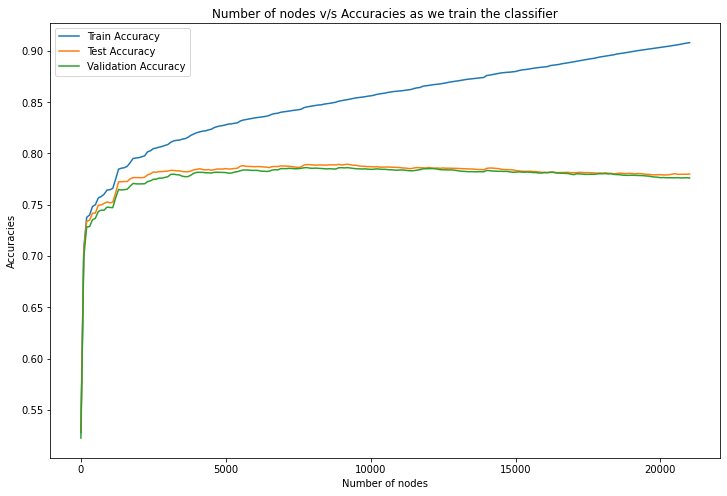

In [11]:
dt_withData=DecisionTreeClassifier(get_train_data=True, get_prune_data=True)

t0=time()
dt_withData.fit(X_train, Y_train, X_test, Y_test, X_val, Y_val)
print('Generated tree in %.2f minutes'%((time()-t0)/60))

train_acc = dt_withData.score(X_train, Y_train)
val_acc = dt_withData.score(X_val, Y_val)
test_acc = dt_withData.score(X_test, Y_test)

print('Train Accuracy :',train_acc*100)
print('Test Accuracy :',test_acc*100)
print('Validation Accuracy :',val_acc*100)

print('\n\n'+str(dt_withData))
dt_withData.plot_training_data()

Pruned tree in 143.00 seconds

After Pruning : 

Train Accuracy : 83.48245329377406
Test Accuracy : 79.81549302304019
Validation Accuracy : 82.52364175783423


DecisionTreeClassifier

Parameters : 
	get_train_data=True
	record_data_frequency=100

Attributes : 
	Total Number of nodes=4617
	Number of leafe nodes=2309


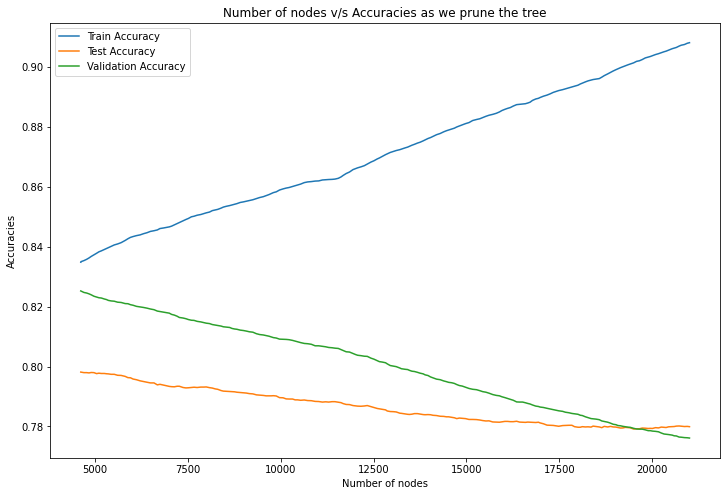

In [12]:
#Prunning The Tree that we got in above part
t0=time()
dt_withData.prune(X_val, Y_val, X_train, Y_train, X_test, Y_test)
print('Pruned tree in %.2f seconds'%(time()-t0))

train_acc = dt_withData.score(X_train, Y_train)
val_acc = dt_withData.score(X_val, Y_val)
test_acc = dt_withData.score(X_test, Y_test)

print('\nAfter Pruning : \n')
print('Train Accuracy :',train_acc*100)
print('Test Accuracy :',test_acc*100)
print('Validation Accuracy :',val_acc*100)

print('\n\n'+str(dt_withData))
dt_withData.plot_pruning_data()